In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [303]:
import datetime

In [304]:
color_scheme1 = plt.cm.get_cmap('tab20c')
color_scheme2 = plt.cm.get_cmap('tab20c')

In [305]:
fig_size = (13, 8)

In [306]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [307]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [308]:
def pivot_data(data_frame, column_name):
    """
    Function to extract the data by column type
    
    return a dataframe
    """
    data_frame.loc[data_frame['ncumul_conf'] == 0.0, column_name] = np.nan
    pivot = pd.DataFrame(pd.pivot_table(data_frame, 
                                        values=column_name, 
                                        index='date', 
                                        columns=['abbreviation_canton_and_fl'], 
                                        aggfunc=np.sum, 
                                        dropna=True))
    new_df = pd.DataFrame(pivot.to_records()).drop(columns="FL")
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

# Data

data from 

https://github.com/openZH/covid_19 for the data about the covid-19

https://github.com/daenuprobst/covid19-cases-switzerland for the demography and geographical data 

In [309]:
# url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/demographics.csv"

In [310]:
# demography = pd.read_csv(url, index_col="Canton")
demography = pd.read_csv("demography.csv", index_col="canton")

In [311]:
demography.to_excel(xl_writer, "Demographic data")

In [312]:
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"

In [313]:
df = pd.read_csv(url)

In [314]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'ncumul_hosp', 'ncumul_ICU', 'ncumul_vent',
       'ncumul_released', 'ncumul_deceased', 'source'],
      dtype='object')

In [315]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [316]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [317]:
df.to_excel(xl_writer, sheet_name="Raw")

# Data extraction

### Extract cases

In [318]:
cases = pivot_data(df, 'ncumul_conf')

In [319]:
cases.to_excel(xl_writer, "Cases")

In [320]:
cases_by_day = pd.concat([cases[cases.columns[0]], cases[cases.columns[1:]].diff()], axis=1)

In [321]:
cases_by_day.to_excel(xl_writer, "Cases by day")

### Extract Deaths

In [322]:
deaths = pivot_data(df, 'ncumul_deceased')

In [323]:
deaths.to_excel(xl_writer, "Deceased Cumulative")

In [324]:
# First columns is the date
daily_deaths = pd.concat([deceased[deaths.columns[0]], deaths[deaths.columns[1:]].diff()], axis=1)

In [325]:
daily_deaths.to_excel(xl_writer, "Daily Deaths")

### Extract Summary

In [326]:
df_summary = pd.concat([pd.to_numeric(cases.max().drop(['date']), downcast="integer"), 
                    pd.to_numeric(deaths.max().drop(['date']), errors='coerce', downcast="integer"),
                   demography,
                   ], 
                    axis=1)

In [327]:
df_summary.columns = ["cases", "deaths"] + list(df_summary.columns[2:])

In [328]:
df_summary.loc[df_summary["deaths"].isna(), "deaths"] = 0

In [329]:
df_summary.sort_values(by="cases", ascending=False, inplace=True)

In [330]:
df_summary.loc[df_summary["cases"] != 0, "rate"] = (df_summary["deaths"] * 100)/ df_summary["cases"]

In [331]:
df_summary["cases per million"] = df_summary["cases"].astype('int32') * 1000 / df_summary["population"]

In [332]:
df_summary["deaths per million"] = df_summary["deaths"].astype('int32') * 1000 / df_summary["population"]

In [333]:
df_summary.to_excel(xl_writer, "Summary")

In [334]:
df_summary

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
CH,25407,1106.0,8544.5,25.1,84.8,213.7,4.353131,2973.491720,129.439991
VD,4560,228.0,799.1,33.2,89.6,283.3,5.000000,5706.419722,285.320986
GE,4357,153.0,499.5,40.0,100.0,2032.1,3.511591,8722.722723,306.306306
ZH,3004,70.0,1521.0,26.9,99.3,915.8,2.330226,1975.016437,46.022354
TI,2869,244.0,353.3,27.8,92.8,129.1,8.504705,8120.577413,690.631192
VS,1616,86.0,344.0,22.7,78.8,66.0,5.321782,4697.674419,250.000000
BE,1441,49.0,1035.0,16.3,74.7,177.2,3.400416,1392.270531,47.342995
BS,882,33.0,194.8,36.4,100.0,5271.1,3.741497,4527.720739,169.404517
AG,878,18.0,678.2,25.1,85.0,486.1,2.050114,1294.603362,26.540843
FR,846,54.0,318.7,22.7,74.9,200.4,6.382979,2654.534045,169.438343


In [335]:
xl_writer.close()

# Analysis Switzeland

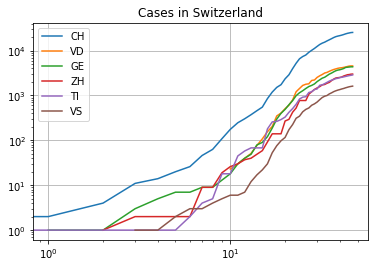

In [336]:
cases[df_summary.index[:6]].plot(logy=True, logx=True, grid=True, title="Cases in Switzerland")

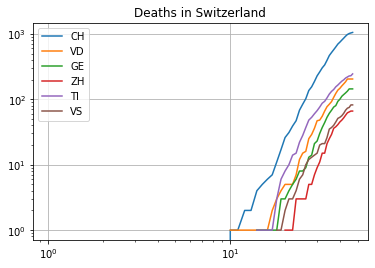

In [337]:
deceased[df_summary.index[:6]].plot(logx=True, logy=True, grid=True, title="Deaths in Switzerland")

# Analysis by Canton

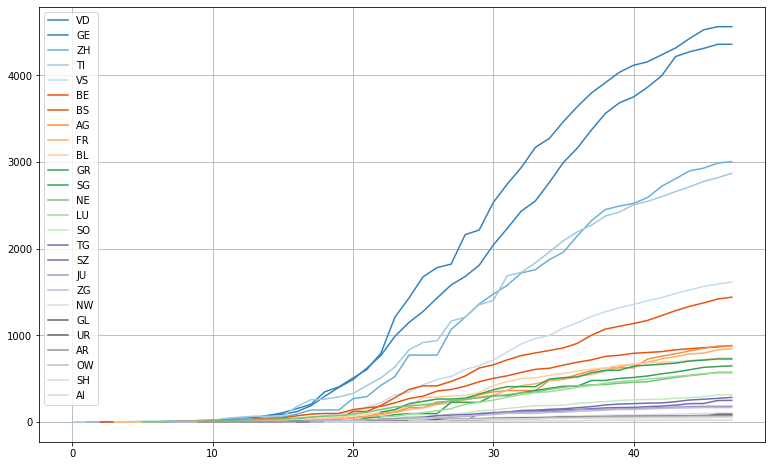

In [338]:
cases[df_summary.index[1:]].plot(figsize=fig_size, grid=True, cmap=color_scheme1)

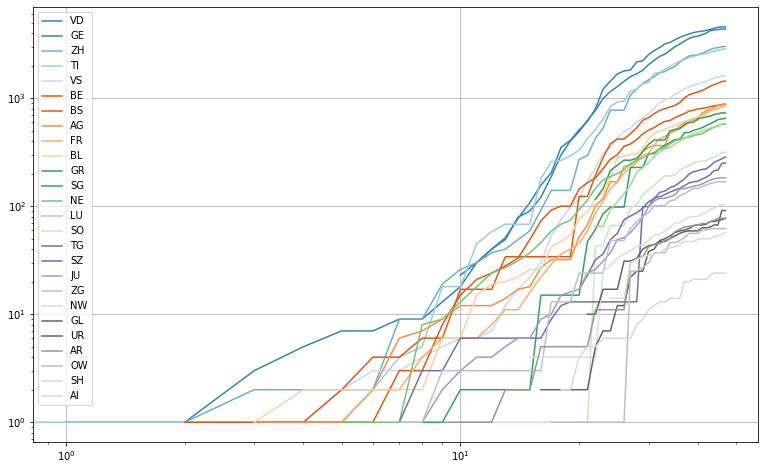

In [339]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, grid=True, cmap=color_scheme1)

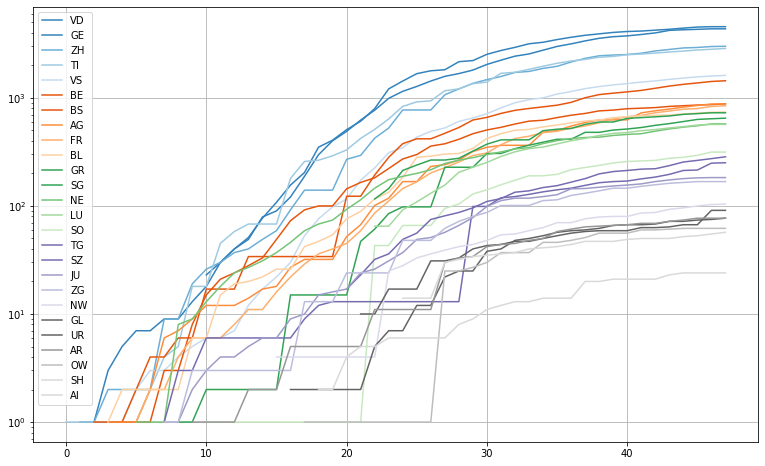

In [340]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, grid=True, cmap=color_scheme1)

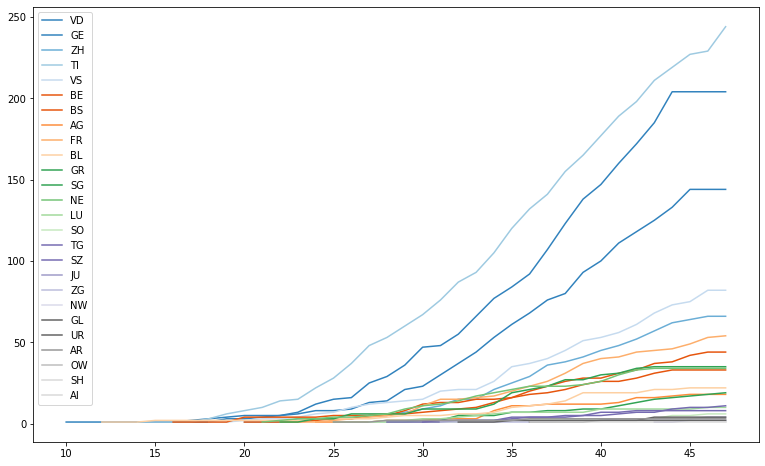

In [341]:
deceased[df_summary.index[1:]].plot(figsize=fig_size, cmap=color_scheme1)

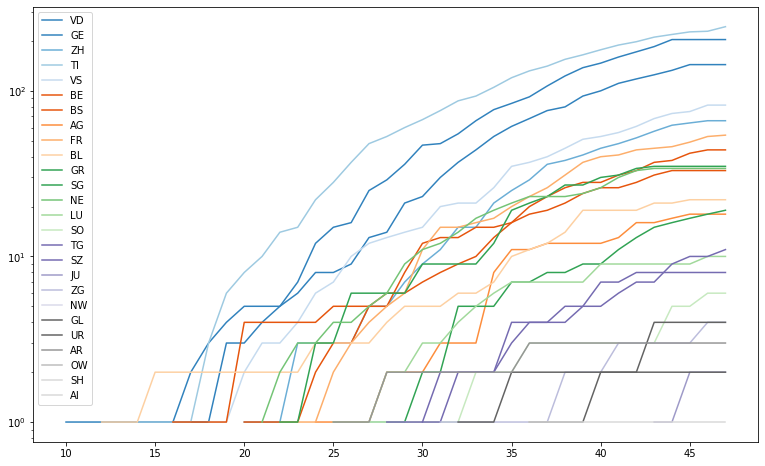

In [342]:
deceased[df_summary.index[1:]].plot(figsize=fig_size, logy=True, cmap=color_scheme1)

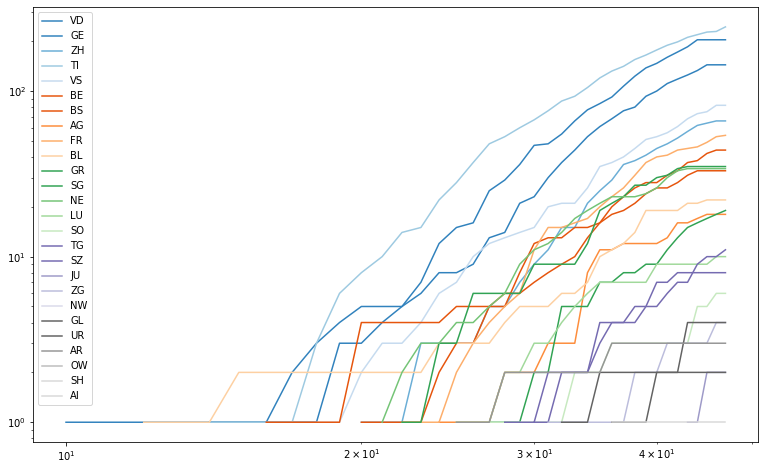

In [343]:
deceased[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, cmap=color_scheme1)

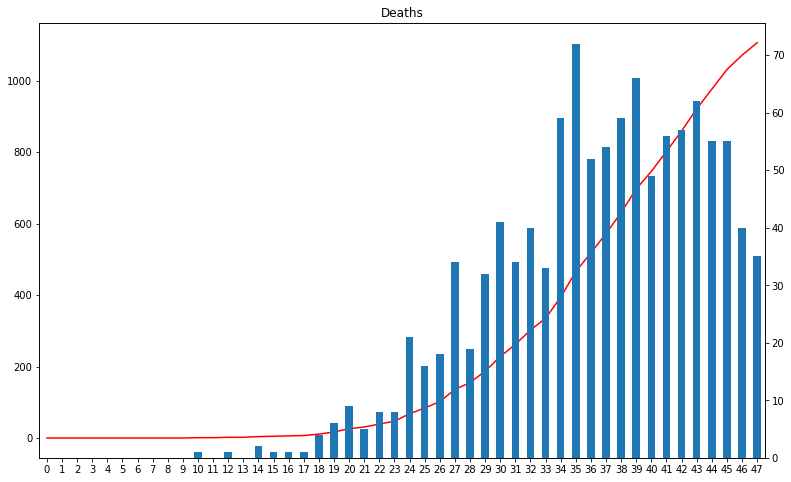

In [344]:
deaths["CH"].plot(figsize=fig_size, color="r", title="Deaths")
daily_deaths["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

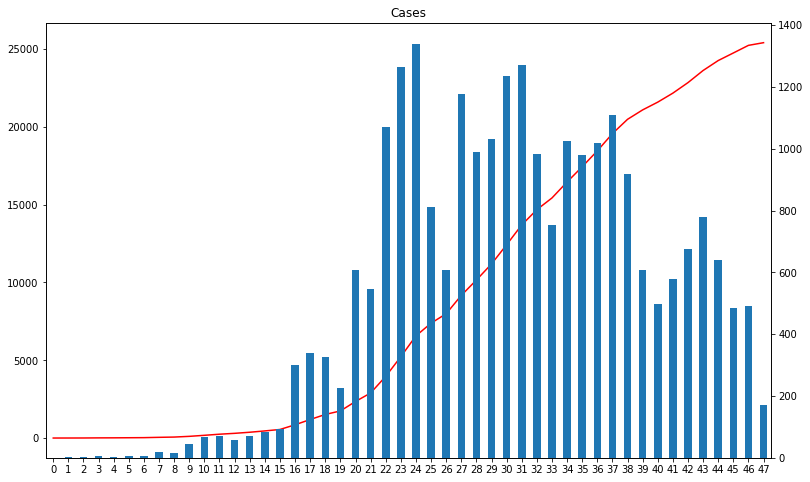

In [345]:
cases["CH"].plot(figsize=fig_size, color="r", title="Cases")
cases_by_day["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

In [346]:
ch = pd.concat([cases['CH'], deceased['CH']], axis=1)

In [347]:
ch.columns = ["Cases", "Deaths"]

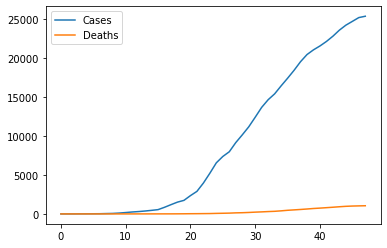

In [348]:
ch.plot()

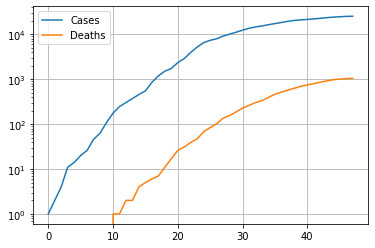

In [349]:
ch.plot(logy=True, grid=True)

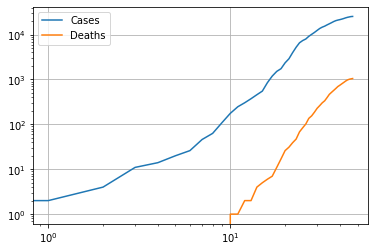

In [350]:
ch.plot(logy=True, logx=True, grid=True)

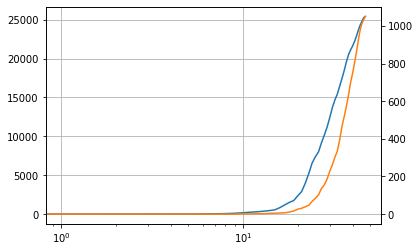

In [351]:
ch["Cases"].plot(logx=True, grid=True)
ch["Deaths"].plot(secondary_y=True, logx=True, grid=True)

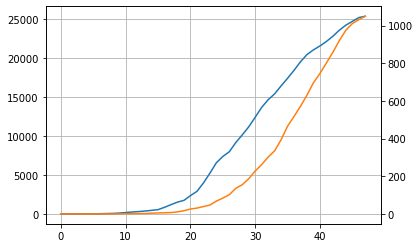

In [352]:
ch["Cases"].plot(grid=True)
ch["Deaths"].plot(secondary_y=True, grid=True)

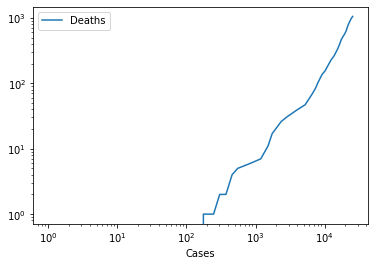

In [353]:
ch.plot(x="Cases", y="Deaths", logx=True, logy=True)

In [354]:
def plot_correlation_matrix(df):
    fig, ax = plt.subplots(figsize=(16, 16))
    im = ax.imshow(df.corr(), cmap="autumn")
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticklabels(df.columns, fontsize=12)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Correlation Matrix")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()


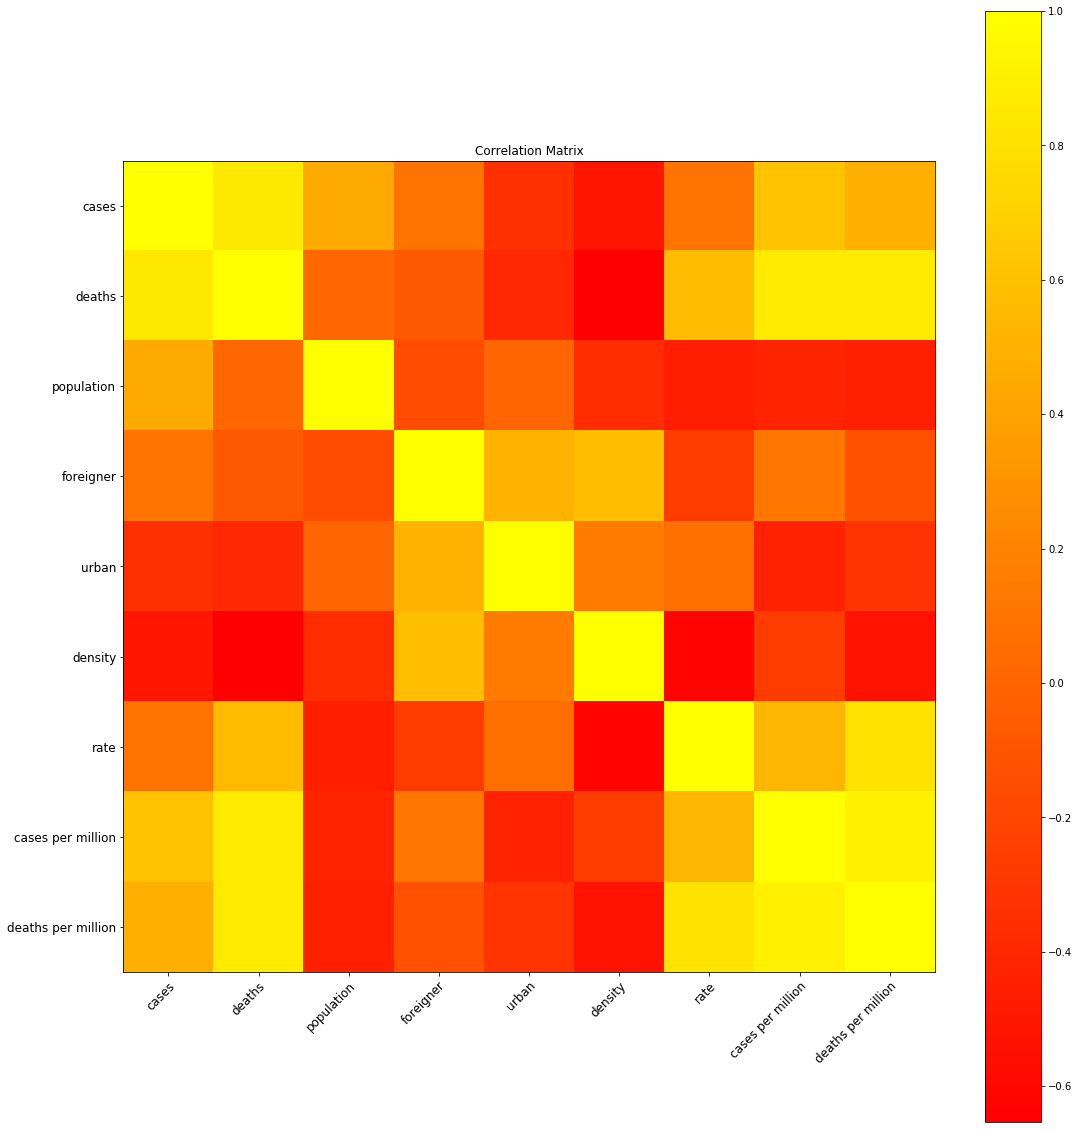

In [355]:
plot_correlation_matrix(df_summary.drop("CH").corr())

In [356]:
corr = df_summary.drop("CH").corr()

In [357]:
corr

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
cases,1.000000,0.897273,0.653012,0.648107,0.406731,0.208988,0.384181,0.769181,0.639210
deaths,0.897273,1.000000,0.419842,0.559179,0.347898,0.086050,0.598136,0.849581,0.872840
population,0.653012,0.419842,1.000000,0.325229,0.363197,0.075352,0.106572,0.116281,0.103936
foreigner,0.648107,0.559179,0.325229,1.000000,0.700555,0.608010,0.347050,0.581960,0.465944
urban,0.406731,0.347898,0.363197,0.700555,1.000000,0.357603,0.507583,0.285597,0.340389
density,0.208988,0.086050,0.075352,0.608010,0.357603,1.000000,0.018266,0.323798,0.121500
rate,0.384181,0.598136,0.106572,0.347050,0.507583,0.018266,1.000000,0.542053,0.789348
cases per million,0.769181,0.849581,0.116281,0.581960,0.285597,0.323798,0.542053,1.000000,0.878122
deaths per million,0.639210,0.872840,0.103936,0.465944,0.340389,0.121500,0.789348,0.878122,1.000000


In [358]:
corr.to_excel(xl_writer, "Correlation Matrix")

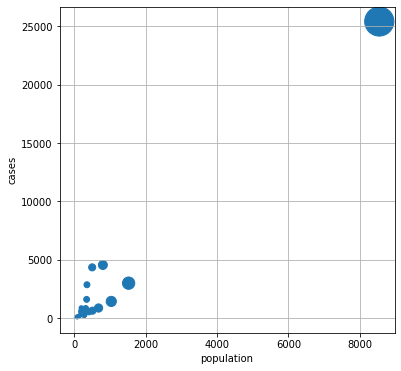

In [359]:
df_summary.plot.scatter(y="cases", 
                    x="population", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

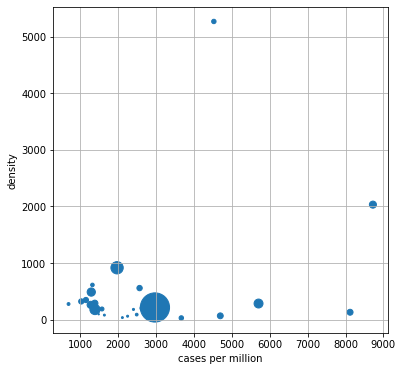

In [360]:
df_summary.plot.scatter(x="cases per million", 
                    y="density",  
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

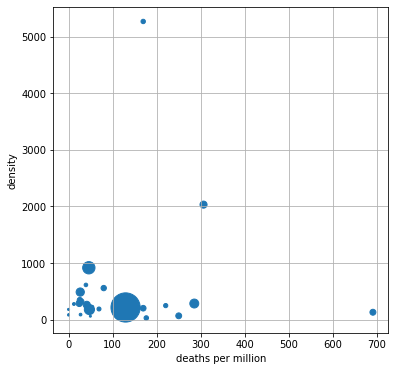

In [361]:
df_summary.plot.scatter(x="deaths per million", 
                    y="density", 
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

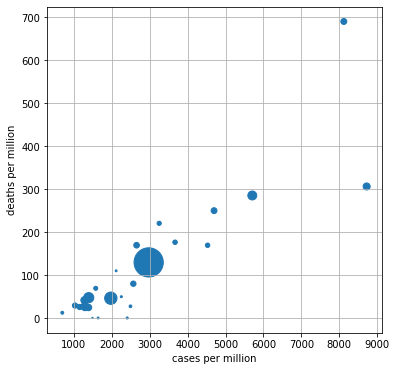

In [362]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

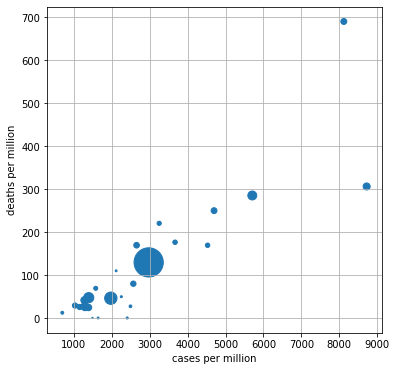

In [363]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

In [364]:
number_of_canton = 15

In [366]:
canton = pd.concat([df_summary[["cases", "deaths"]].drop("CH").iloc[:number_of_canton], 
                pd.DataFrame([df_summary[["cases", "deaths"]].drop("CH").iloc[number_of_canton:].sum(),])])

In [367]:
canton.rename(index={0: 'others'}, inplace=True)

In [368]:
canton.sort_values(by="cases", ascending=False, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe9aebffd0>,
      dtype=object)

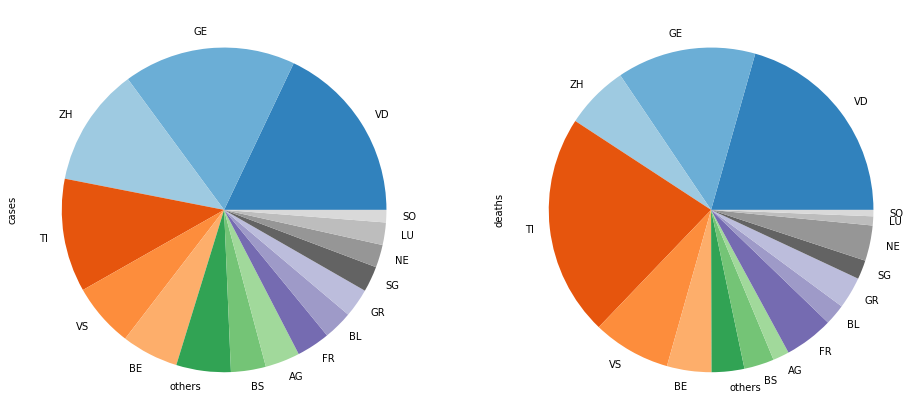

In [369]:
canton.plot.pie(subplots=True, figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'), legend=False)

In [370]:
df_summary.sort_values(by="cases per million", inplace=True, ascending=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe9adb77d0>,
      dtype=object)

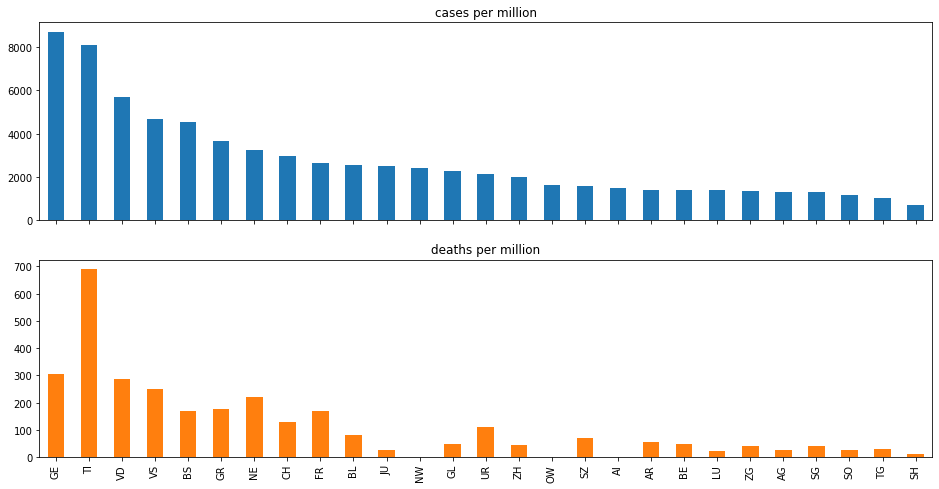

In [371]:
df_summary[["cases per million","deaths per million"]].plot.bar(subplots=True, figsize=(16, 8), legend=False)